In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    RocCurveDisplay
    )

In [17]:
df = pd.read_csv("../dataset/dt_full_analysis.csv")

In [18]:
numeric_columns = [
    'user_id', 'age', 'sex_num', 'last_month_salary', 'number_dependents',
    'total_emprestimos', 'qtd_real_estate', 'qtd_others',
    'perc_real_estate', 'perc_others', 'more_90_days_overdue',
    'using_lines_not_secured_personal_assets',
    'number_times_delayed_payment_loan_30_59_days', 'debt_ratio',
    'number_times_delayed_payment_loan_60_89_days', 'default_flag'
    ]
df_numeric = df[numeric_columns]

## EDA

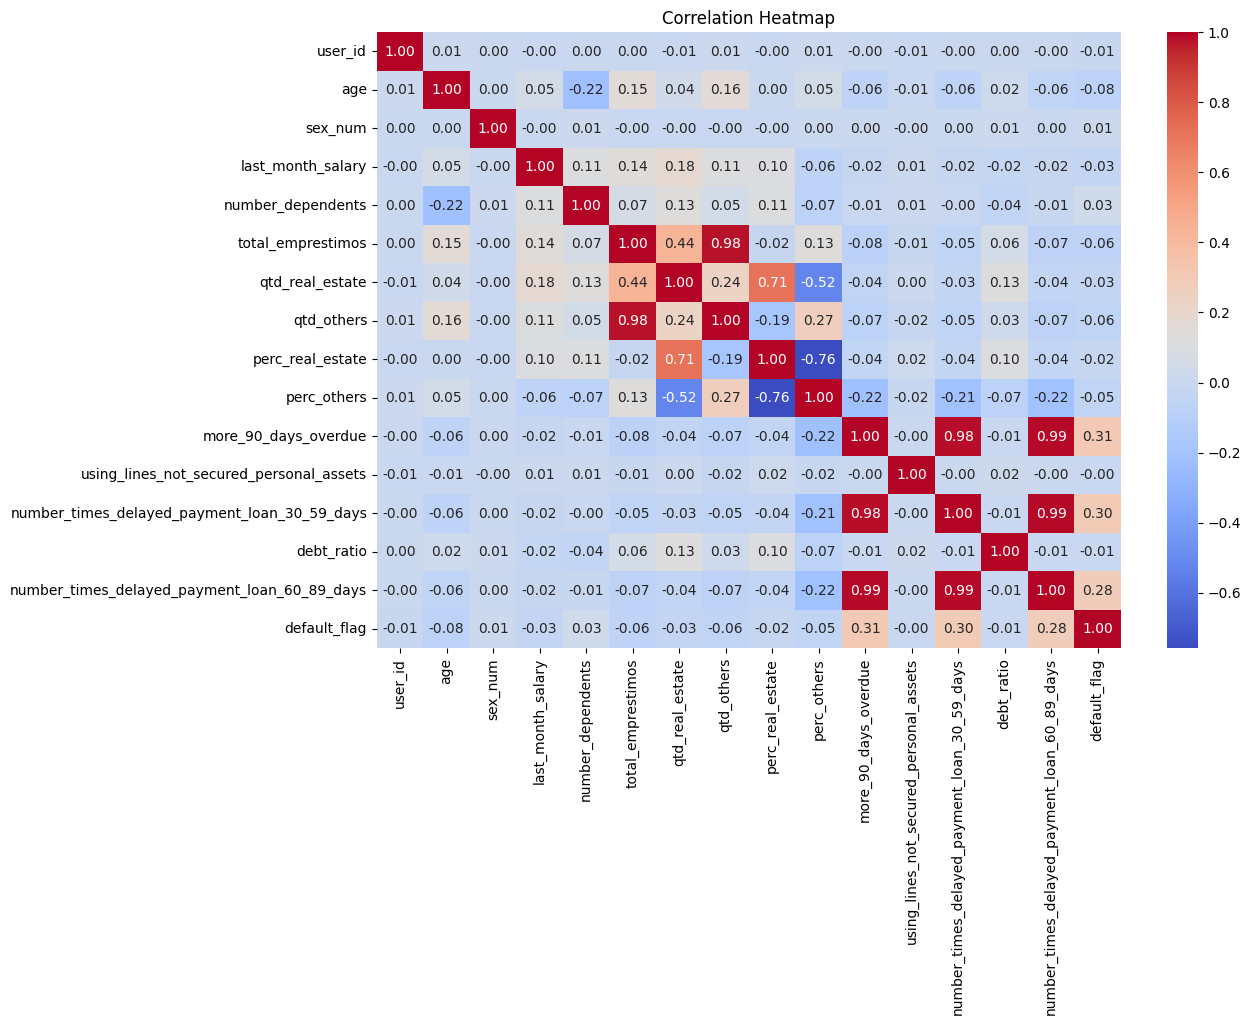

In [19]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

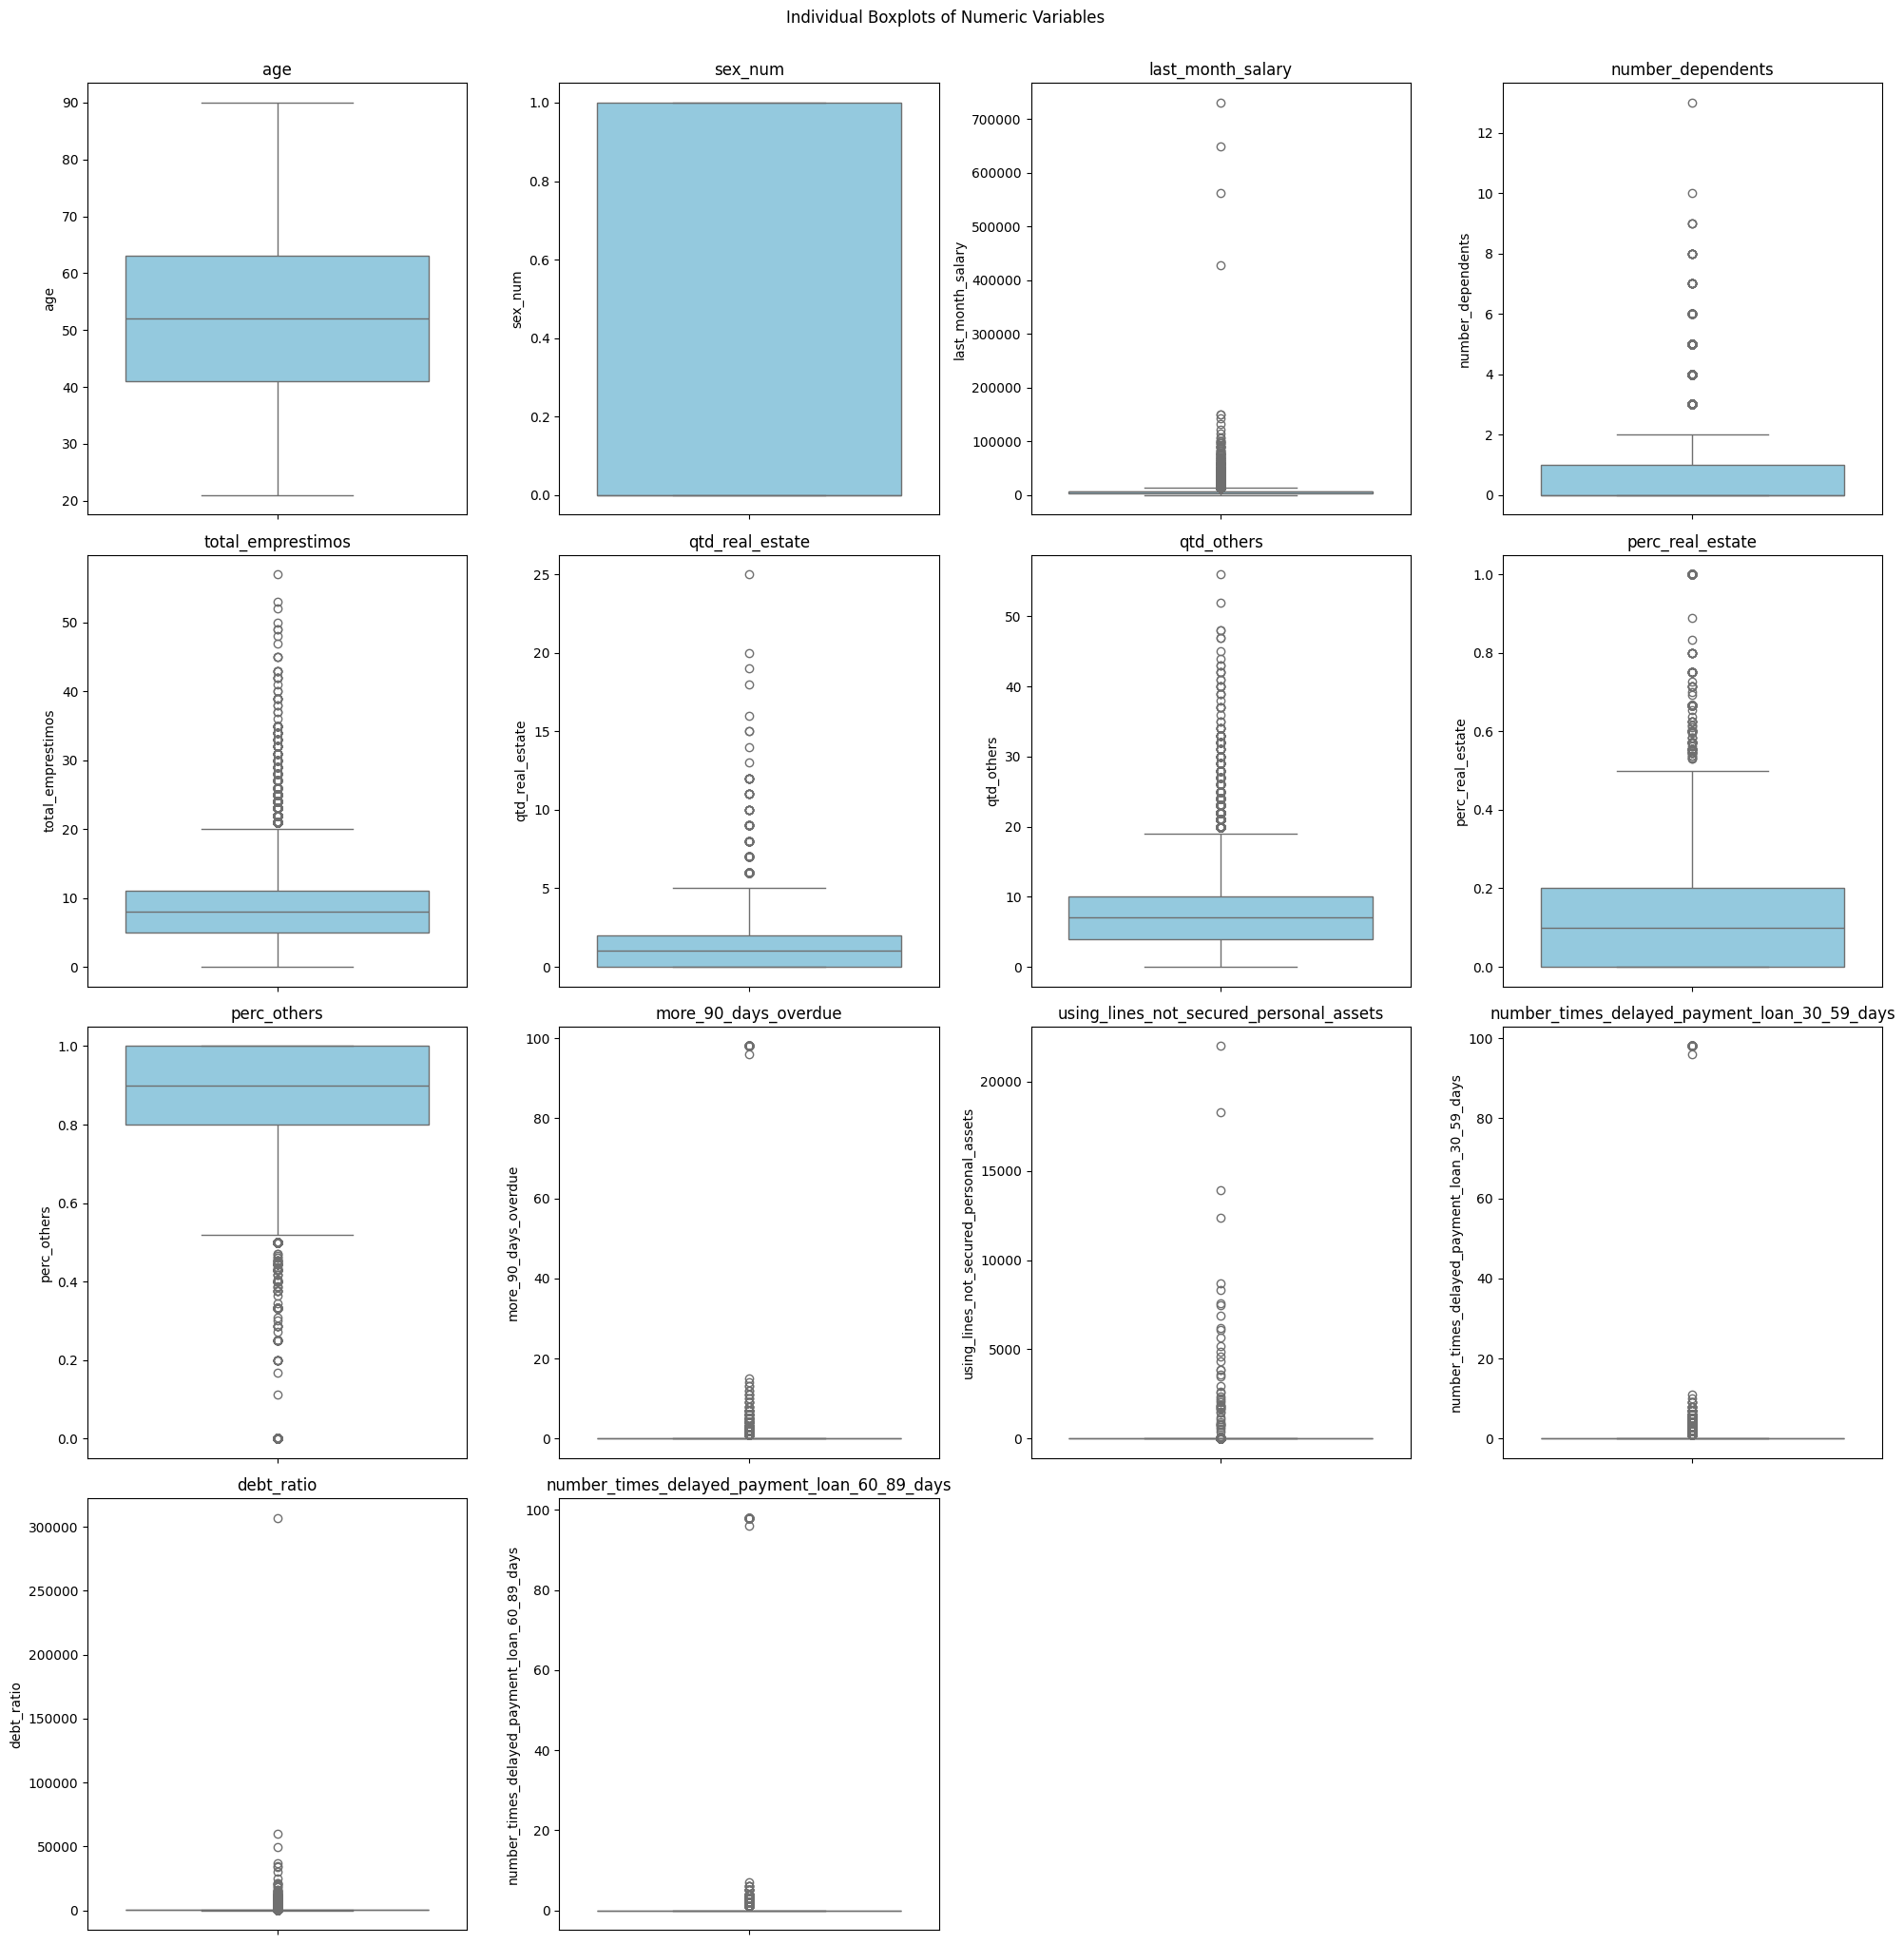

In [20]:
boxplot_columns = [col for col in df_numeric.columns if col not in ['user_id', 'default_flag']]
n_cols = 4
n_rows = int(np.ceil(len(boxplot_columns) / n_cols))
plt.figure(figsize=(5 * n_cols, 5 * n_rows))
for i, col in enumerate(boxplot_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=df_numeric[col], color='skyblue')
    plt.title(col)
    plt.tight_layout()
plt.suptitle('Individual Boxplots of Numeric Variables', y=1.02)
plt.show()

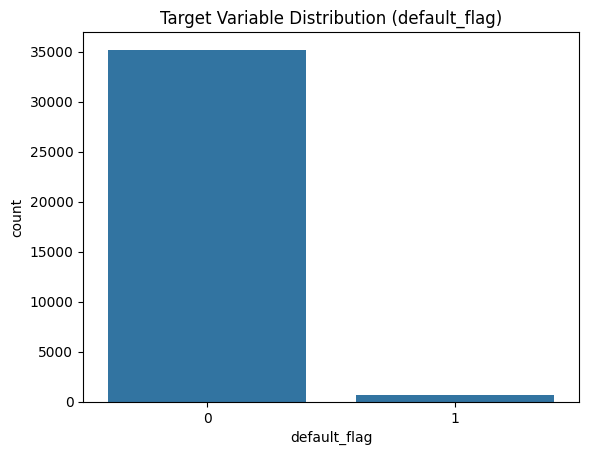

In [21]:
sns.countplot(x='default_flag', data=df_numeric)
plt.title('Target Variable Distribution (default_flag)')
plt.show()

## Regressão logística

In [22]:
y = df_numeric["default_flag"]
X = df_numeric.drop(columns=["default_flag"])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
    )

In [24]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

c:\Users\Vitoria\anaconda3\envs\py12_lab\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [25]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10559
           1       0.67      0.16      0.26       205

    accuracy                           0.98     10764
   macro avg       0.83      0.58      0.63     10764
weighted avg       0.98      0.98      0.98     10764



In [27]:
print(confusion_matrix(y_test, y_pred))

[[10543    16]
 [  172    33]]


In [28]:
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc:.3f}")

AUC: 0.790


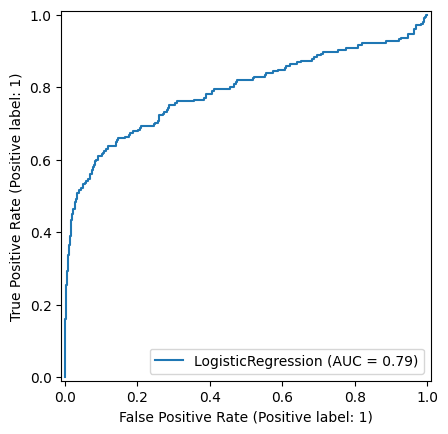

In [29]:
RocCurveDisplay.from_estimator(logreg, X_test, y_test)
plt.show()

In [30]:
coefficients = pd.DataFrame({
    "variable": X.columns,
    "coefficient": logreg.coef_[0]
})
coefficients["odds_ratio"] = np.exp(coefficients["coefficient"])
coefficients.sort_values(by="odds_ratio", ascending=False, inplace=True)
print(coefficients)

                                        variable  coefficient  odds_ratio
10                          more_90_days_overdue     0.847568    2.333964
12  number_times_delayed_payment_loan_30_59_days     0.639581    1.895686
4                              number_dependents     0.131902    1.140997
6                                qtd_real_estate     0.074142    1.076960
5                              total_emprestimos     0.011030    1.011091
8                               perc_real_estate     0.000752    1.000752
0                                        user_id    -0.000027    0.999973
13                                    debt_ratio    -0.000061    0.999939
3                              last_month_salary    -0.000147    0.999853
11       using_lines_not_secured_personal_assets    -0.000473    0.999527
2                                        sex_num    -0.013552    0.986540
1                                            age    -0.053023    0.948359
7                                     

Coeficiente positivo → aumenta a chance de inadimplência.

Coeficiente negativo → reduz a chance de inadimplência.

Odds Ratio (impacto) → facilita interpretação (ex.: valor 1.5 = aumenta 50% na chance de inadimplência).

In [31]:
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Criar DataFrame
roc_df = pd.DataFrame({
    "FPR (False Positive Rate)": fpr,
    "TPR (True Positive Rate)": tpr,
    "Threshold": thresholds
})

# Salvar em CSV
roc_df.to_csv("roc_curve_data.csv", index=False)